In [1]:
import gymnasium as gym
import highway_env
import matplotlib.pyplot as plt
import torch

# Define environment configuration using kinematic matrix as info
config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False,
        "order": "sorted"
    },
    "action": {                         # Define continous x and y actions
        "type": "ContinuousAction",
        "longitudinal": True,
        "lateral": True,
        
        # Original steering -> struggling to turn enough to avoid car
        # "steering_range": [-0.15, 0.15], 

        # Improved steering -> easier to overtake
        "steering_range": [-0.3, 0.3],  
        
        # Original speed range -> agent learnt that slow and no overtakes was good
        # "speed_range": [10, 30]

        # Improved speed range -> agent must learn to overtake
        "speed_range": [15, 30]
    },
    "simulation_frequency": 15, # Physics updates per second
    "policy_frequency": 5,      # Decisions per second (0.2s reaction time)
    "duration": 40, 
    "offroad_terminal": True,
    "lanes_count": 4, 
}

# Create environment and display example state input
env = gym.make('highway-fast-v0', config=config, render_mode='rgb_array')
obs, info = env.reset()
print(obs.shape)


c:\Users\marce\OneDrive\Documents\BathLife\Y3\RL\CS1\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


(15, 7)


In [2]:
from SAC import SAC

# Create a dummy agent
agent = SAC(env, state_size=105)

# Create a fake input batch: 32 
fake_state = torch.randn(32, 15, 7)
fake_action = torch.randn(32, 2)

# 1. Test Actor
print("Testing Actor...")
mu, log_std = agent.actor(fake_state)
print(f"Actor Output Shape: {mu.shape}") 

# 2. Test Critic
print("Testing Critic...")
q_val = agent.critic_1(fake_state, fake_action) 
print(f"Critic Output Shape: {q_val.shape}") 

print("Correct dimensions!")

Testing Actor...
Actor Output Shape: torch.Size([32, 2])
Testing Critic...
Critic Output Shape: torch.Size([32, 1])
Correct dimensions!


Step-milestone: 0
Step 9: Episode Reward: 7.114532420845101
Step 29: Episode Reward: 15.021587737243593
Step 39: Episode Reward: 7.270945166568081
Step 45: Episode Reward: 4.1104982647202375
Step 50: Episode Reward: 3.4897741612409154
Step 65: Episode Reward: 10.64492455198245
Step 72: Episode Reward: 4.811135758072255
Step 82: Episode Reward: 7.498186539686437
Step 96: Episode Reward: 9.776351504556887
Step 99: Episode Reward: 1.5077024661492278
Step 101: Episode Reward: 0.7903330801410632
Step 105: Episode Reward: 2.3558537393222156
Step 119: Episode Reward: 10.565444488776444
Step 123: Episode Reward: 2.487734803289328
Step 140: Episode Reward: 13.410251730789716
Step 148: Episode Reward: 5.548225349260637
Step 152: Episode Reward: 2.4773724217949438
Step 155: Episode Reward: 1.7581483874127135
Step 158: Episode Reward: 1.5553614576014936
Step 169: Episode Reward: 7.512756761524072
Step 171: Episode Reward: 0.8095374778982336
Step 188: Episode Reward: 13.1388942169363
Step 208: Epis

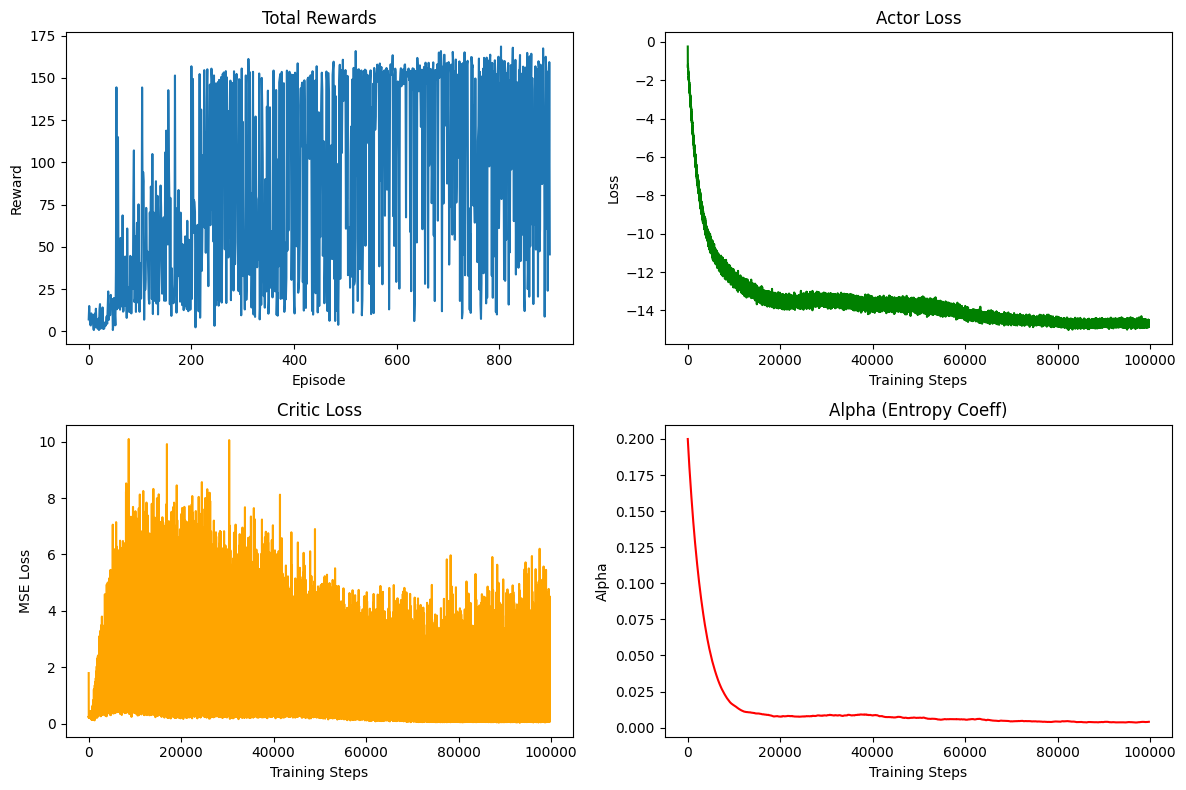

Data saved to results/sac_kinematics_data.npz


<Figure size 640x480 with 0 Axes>

In [3]:
# Main Loop Test
import numpy as np

# 1. Train agent and collect losses and rewards over episodes 
rewards, critic_losses, actor_losses, alphas = agent.train_loop()

# 2. Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot A: Rewards (Per Episode)
axes[0,0].plot(rewards)
axes[0,0].set_title("Total Rewards")
axes[0,0].set_xlabel("Episode") 
axes[0,0].set_ylabel("Reward")

# Plot B: Critic Loss (Per Step)
axes[1,0].plot(critic_losses, color='orange')
axes[1,0].set_title("Critic Loss")
axes[1,0].set_xlabel("Training Steps")
axes[1,0].set_ylabel("MSE Loss")

# Plot C: Actor Loss (Per Step)
axes[0,1].plot(actor_losses, color='green')
axes[0,1].set_title("Actor Loss")
axes[0,1].set_xlabel("Training Steps") 
axes[0,1].set_ylabel("Loss")

# Plot D: Alpha Decay (Per Step)
axes[1,1].plot(alphas, color='red')
axes[1,1].set_title("Alpha (Entropy Coeff)")
axes[1,1].set_xlabel("Training Steps") 
axes[1,1].set_ylabel("Alpha")

plt.tight_layout()
plt.show()
plt.savefig("figures/SAC_plots_kinematics.png")

np.savez("results/sac_kinematics_data.npz", 
         rewards=rewards, 
         critic_losses=critic_losses, 
         actor_losses=actor_losses, 
         alphas=alphas)

print("Data saved to results/sac_kinematics_data.npz")

In [4]:
from gymnasium.wrappers import RecordVideo

#agent.load_actor_only("best_model.pth")

# Define class to record test output runs
env = RecordVideo(
    env, 
    video_folder="videos_kinematics/sac_highway", 
    episode_trigger=lambda e: True, # Record every episode
    name_prefix="sac_eval"
)

print("Starting Evaluation...")
NUM_EPISODES = 5

# Evaluation loop, deterministacally stepping in our environment to test our learned actor policy
for episode in range(NUM_EPISODES):
    obs, info = env.reset()
    done = truncated = False
    score = 0
    
    while not (done or truncated):
        action = agent.choose_action_deterministic(obs)
        next_obs, reward, done, truncated, info = env.step(action)
        obs = next_obs
        score += reward
        
    print(f"Recorded Episode {episode + 1}: Score = {score:.2f}")

env.close()
print("Videos saved to 'videos_kinematics/sac_highway' folder.")

c:\Users\marce\OneDrive\Documents\BathLife\Y3\RL\CS1\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\marce\OneDrive\Documents\BathLife\Y3\RL\CS1\algorithms\SAC\videos_kinematics\sac_highway folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Starting Evaluation...
Recorded Episode 1: Score = 34.71
Recorded Episode 2: Score = 74.30
Recorded Episode 3: Score = 12.27
Recorded Episode 4: Score = 154.41
Recorded Episode 5: Score = 111.52
Videos saved to 'videos_kinematics/sac_highway' folder.
